In [62]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

# High-Performance Gradient Boosting
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

# Configuration
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

print("✅ Environment Ready. Libraries loaded.")

✅ Environment Ready. Libraries loaded.


In [24]:
# Cell 2: Data Loading
filename = "CPT_II_ConnersContinuousPerformanceTest.csv"

try:
    # Your file uses semicolons ';'
    data = pd.read_csv(filename, delimiter=";")
    print("✅ File loaded successfully!")
except FileNotFoundError:
    print(f"❌ Error: Could not find '{filename}'. Make sure it is in the same folder as this notebook.")
    raise

# 1. Clean Column Names (remove spaces)
data.columns = data.columns.str.strip()

# 2. Rename Target Column for consistency
if "Adhd Confidence Index" in data.columns:
    data.rename(columns={"Adhd Confidence Index": "label"}, inplace=True)

# 3. Check for Target
if "label" not in data.columns:
    raise ValueError("❌ Target column 'Adhd Confidence Index' not found!")

# 4. Drop ID Column (Prevents the model from memorizing patient IDs)
if "ID" in data.columns:
    data = data.drop(columns=["ID"])
    print("ℹ️ Dropped 'ID' column to prevent data leakage.")

# 5. Fix European Decimal Format (e.g., converting "5,4" to "5.4")
# We apply this to all columns to be safe
data = data.applymap(lambda x: str(x).replace(",", ".") if isinstance(x, str) else x)
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors="ignore")

print(f"📊 Dataset Shape: {data.shape[0]} rows, {data.shape[1]} columns")
data.head(3)

✅ File loaded successfully!
ℹ️ Dropped 'ID' column to prevent data leakage.
📊 Dataset Shape: 99 rows, 785 columns


,Assessment Status,Assessment Duration,Type,LastTrial,Trial1,Response1,Trial2,Response2,Trial3,Response3,Trial4,Response4,Trial5,Response5,Trial6,Response6,Trial7,Response7,Trial8,Response8,Trial9,Response9,Trial10,Response10,Trial11,Response11,Trial12,Response12,Trial13,Response13,Trial14,Response14,Trial15,Response15,Trial16,Response16,Trial17,Response17,Trial18,Response18,Trial19,Response19,Trial20,Response20,Trial21,Response21,Trial22,Response22,Trial23,Response23,Trial24,Response24,Trial25,Response25,Trial26,Response26,Trial27,Response27,Trial28,Response28,Trial29,Response29,Trial30,Response30,Trial31,Response31,Trial32,Response32,Trial33,Response33,Trial34,Response34,Trial35,Response35,Trial36,Response36,Trial37,Response37,Trial38,Response38,Trial39,Response39,Trial40,Response40,Trial41,Response41,Trial42,Response42,Trial43,Response43,Trial44,Response44,Trial45,Response45,Trial46,Response46,Trial47,Response47,Trial48,Response48,Trial49,Response49,Trial50,Response50,Trial51,Response51,Trial52,Response52,Trial53,Response53,Trial54,Response54,Trial55,Response55,Trial56,Response56,Trial57,Response57,Trial58,Response58,Trial59,Response59,Trial60,Response60,Trial61,Response61,Trial62,Response62,Trial63,Response63,Trial64,Response64,Trial65,Response65,Trial66,Response66,Trial67,Response67,Trial68,Response68,Trial69,Response69,Trial70,Response70,Trial71,Response71,Trial72,Response72,Trial73,Response73,Trial74,Response74,Trial75,Response75,Trial76,Response76,Trial77,Response77,Trial78,Response78,Trial79,Response79,Trial80,Response80,Trial81,Response81,Trial82,Response82,Trial83,Response83,Trial84,Response84,Trial85,Response85,Trial86,Response86,Trial87,Response87,Trial88,Response88,Trial89,Response89,Trial90,Response90,Trial91,Response91,Trial92,Response92,Trial93,Response93,Trial94,Response94,Trial95,Response95,Trial96,Response96,Trial97,Response97,Trial98,Response98,Trial99,Response99,Trial100,Response100,Trial101,Response101,Trial102,Response102,Trial103,Response103,Trial104,Response104,Trial105,Response105,Trial106,Response106,Trial107,Response107,Trial108,Response108,Trial109,Response109,Trial110,Response110,Trial111,Response111,Trial112,Response112,Trial113,Response113,Trial114,Response114,Trial115,Response115,Trial116,Response116,Trial117,Response117,Trial118,Response118,Trial119,Response119,Trial120,Response120,Trial121,Response121,Trial122,Response122,Trial123,Response123,Trial124,Response124,Trial125,Response125,Trial126,Response126,Trial127,Response127,Trial128,Response128,Trial129,Response129,Trial130,Response130,Trial131,Response131,Trial132,Response132,Trial133,Response133,Trial134,Response134,Trial135,Response135,Trial136,Response136,Trial137,Response137,Trial138,Response138,Trial139,Response139,Trial140,Response140,Trial141,Response141,Trial142,Response142,Trial143,Response143,Trial144,Response144,Trial145,Response145,Trial146,Response146,Trial147,Response147,Trial148,Response148,Trial149,Response149,Trial150,Response150,Trial151,Response151,Trial152,Response152,Trial153,Response153,Trial154,Response154,Trial155,Response155,Trial156,Response156,Trial157,Response157,Trial158,Response158,Trial159,Response159,Trial160,Response160,Trial161,Response161,Trial162,Response162,Trial163,Response163,Trial164,Response164,Trial165,Response165,Trial166,Response166,Trial167,Response167,Trial168,Response168,Trial169,Response169,Trial170,Response170,Trial171,Response171,Trial172,Response172,Trial173,Response173,Trial174,Response174,Trial175,Response175,Trial176,Response176,Trial177,Response177,Trial178,Response178,Trial179,Response179,Trial180,Response180,Trial181,Response181,Trial182,Response182,Trial183,Response183,Trial184,Response184,Trial185,Response185,Trial186,Response186,Trial187,Response187,Trial188,Response188,Trial189,Response189,Trial190,Response190,Trial191,Response191,Trial192,Response192,Trial193,Response193,Trial194,Response194,Trial195,Response195,Trial196,Response196,Trial197,Response197,Trial198,Response198,Tria

In [81]:
# Cell 3: Train-Test Split
X = data.drop(columns=["label"])
y = data["label"]

# We bin the target variable to stratify the split
# This ensures rare cases (very high ADHD scores) appear in both Train and Test
y_bins = pd.qcut(y, q=10, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y_bins, test_size=0.2, random_state=42
)

print(f"✅ Data Split Complete.")
print(f"   Training Rows: {X_train.shape[0]}")
print(f"   Testing Rows:  {X_test.shape[0]}")

✅ Data Split Complete.
   Training Rows: 79
   Testing Rows:  20


In [85]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LassoCV

# --- 1. Smart Feature Identification ---
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print(f"ℹ️ Processing {len(numeric_cols)} numeric and {len(categorical_cols)} categorical features.")

# --- 2. Optimized Preprocessing ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson')),
    # Added PCA: Crucial for datasets with 700+ cols and <100 rows. 
    # It condenses noise into signal. '0.95' keeps 95% of variance.
    ('pca', PCA(n_components=0.95)) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    verbose_feature_names_out=False
)

# --- 3. The "Small Data" Model Stack ---
# CRITICAL FIX: Reduced complexity to prevent overfitting on 79 rows.
# - max_depth=3 (was 6): Shallow trees generalize better on small data.
# - num_leaves=15 (was 31): Prevents memorizing samples.
# - n_estimators=300 (was 600): Sufficient for small datasets.

lgbm = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.03, num_leaves=15, max_depth=3, n_jobs=-1, verbose=-1, random_state=42)
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.03, max_depth=3, n_jobs=-1, random_state=42)
cat_model = CatBoostRegressor(iterations=300, learning_rate=0.03, depth=4, verbose=0, random_seed=42, thread_count=1)

# Ridge handles multicollinearity well, which is common in high-dim data
ridge_model = Ridge(alpha=1.0)

estimators = [
    ('lgbm', lgbm),
    ('xgb', xgb_model),
    ('cat', cat_model),
    ('ridge', ridge_model)
]

# The "Judge" (Meta-Learner)
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(), 
    cv=5,
    n_jobs=-1,
    passthrough=False 
)

# --- 4. The Magic Wrapper: TransformedTargetRegressor ---
final_model = TransformedTargetRegressor(
    regressor=stacking_model,
    func=np.log1p,       
    inverse_func=np.expm1 
)

# --- 5. Assemble Final Pipeline ---
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Selection: Switched to LassoCV. Linear selection is often better than Tree selection
    # for high-dimensional small data. It effectively kills noisy features (sets weights to 0).
    ('selector', SelectFromModel(LassoCV(random_state=42), threshold="1.25*mean")),
    ('model', final_model)
])

print("✅ Advanced Pipeline Architecture Built (Optimized for Small N, Large P).")

ℹ️ Processing 784 numeric and 0 categorical features.
✅ Advanced Pipeline Architecture Built (Optimized for Small N, Large P).


In [86]:
# Cell 5: Training
print("🚀 Training started... this may take a minute...")

# This one line handles Imputation, Scaling, Selection, and Stacking
full_pipeline.fit(X_train, y_train)

print(" Training Complete!")

🚀 Training started... this may take a minute...
 Training Complete!


 Generating Predictions...

🏆 FINAL PERFORMANCE REPORT
R² Score (Accuracy): 0.6883  (Closer to 1.0 is better)
RMSE (Avg Error):    12.7956 (Lower is better)
MAE (Abs Error):     9.1633


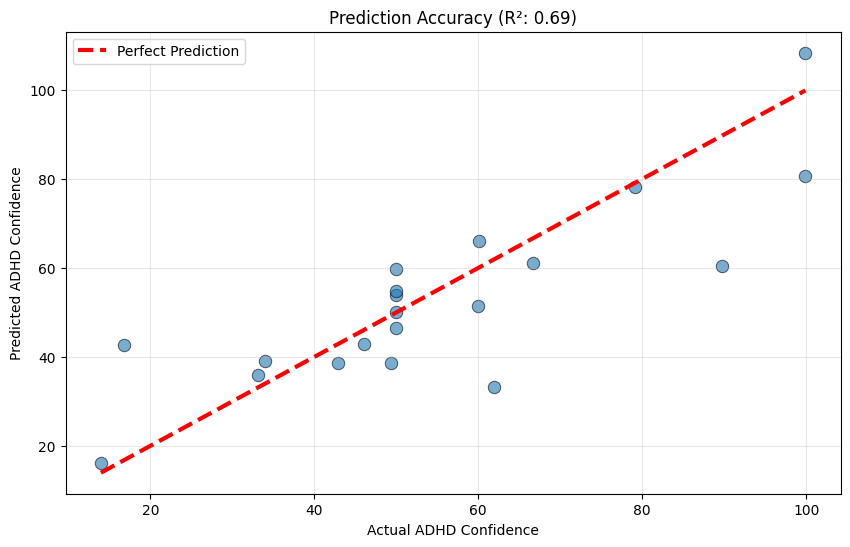

In [87]:
# Cell 6: Evaluation
print(" Generating Predictions...")
y_pred = full_pipeline.predict(X_test)

# Calculate Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n" + "="*40)
print(f"🏆 FINAL PERFORMANCE REPORT")
print("="*40)
print(f"R² Score (Accuracy): {r2:.4f}  (Closer to 1.0 is better)")
print(f"RMSE (Avg Error):    {rmse:.4f} (Lower is better)")
print(f"MAE (Abs Error):     {mae:.4f}")
print("="*40)

# Visual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor='k', s=80)

# Using y_test for the range limits to ensure self-containment
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label='Perfect Prediction')

plt.xlabel("Actual ADHD Confidence")
plt.ylabel("Predicted ADHD Confidence")
plt.title(f"Prediction Accuracy (R²: {r2:.2f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [89]:
# Cell 7: Save Model
model_filename = "adhd_final_model.joblib"
joblib.dump(full_pipeline, model_filename)

print(f"✅ Model saved as '{model_filename}'")
print(f"   Size: {round(pd.io.common.os.path.getsize(model_filename) / 1024 / 1024, 2)} MB")

✅ Model saved as 'adhd_final_model.joblib'
   Size: 1.02 MB


✅ SHAP Explanation calculated successfully!


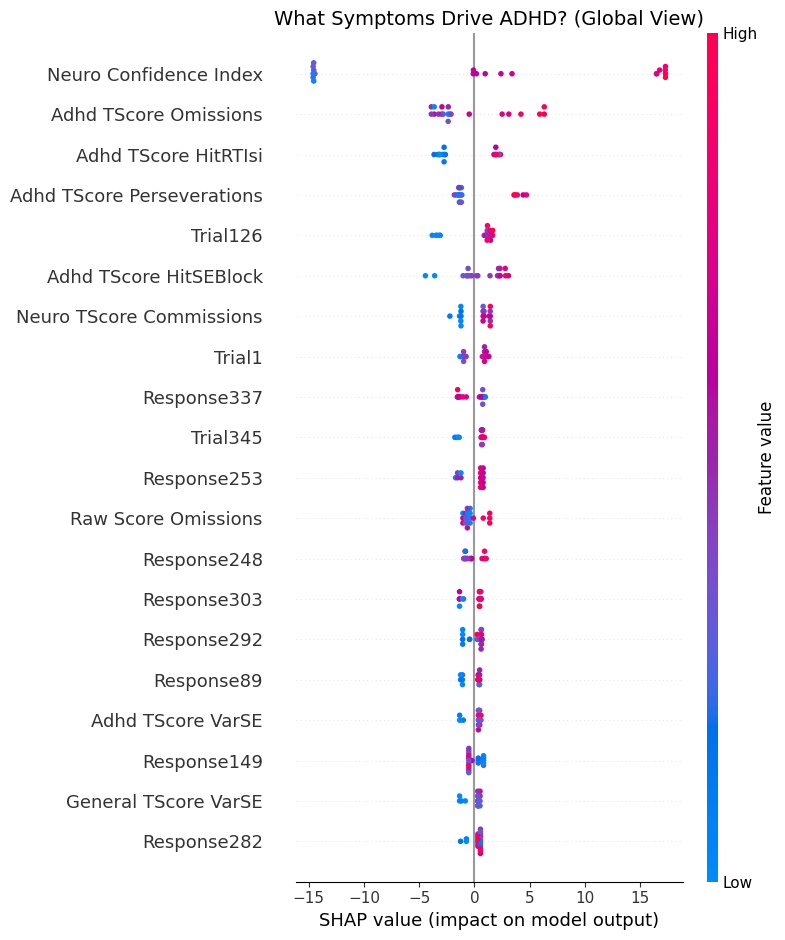

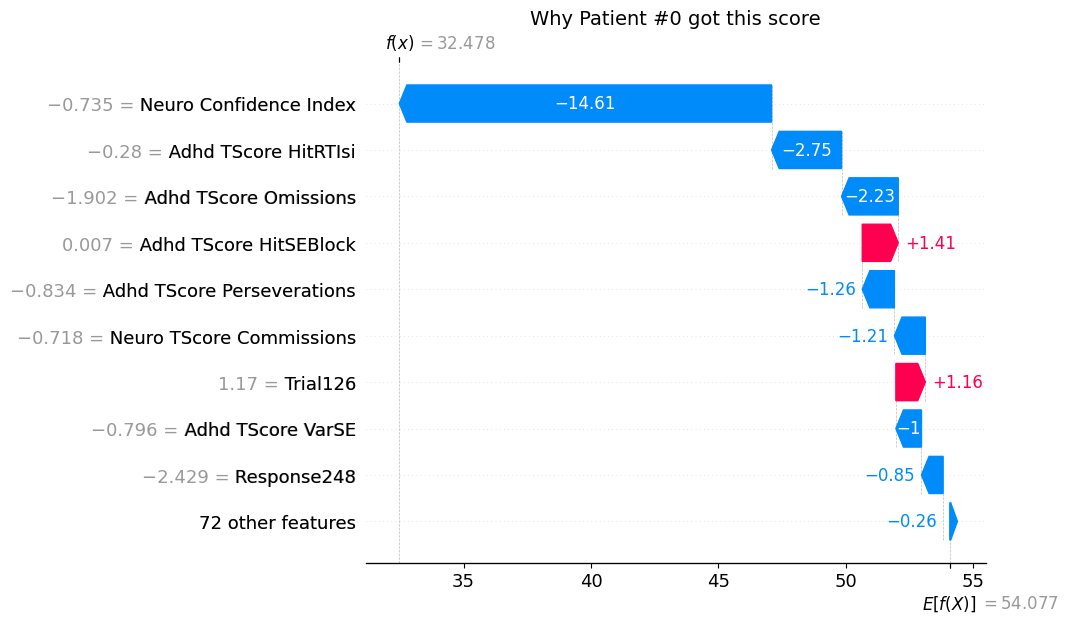

In [13]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PREPARE DATA ---
preprocessor = full_pipeline.named_steps['preprocessor']
selector = full_pipeline.named_steps['selector']

# Transform test data
X_test_transformed = preprocessor.transform(X_test)
X_test_selected = selector.transform(X_test_transformed)

# --- THE FIX ---
# Instead of digging into 'num' and 'cat' separately, we ask the main preprocessor
# to generate ALL feature names in the correct order automatically.
all_features = preprocessor.get_feature_names_out()

# Filter them based on the selector
selected_indices = selector.get_support(indices=True)
selected_features = [all_features[i] for i in selected_indices]

# --- 2. CALCULATE SHAP ---
lgbm_model = full_pipeline.named_steps['model'].estimators_[0]
explainer = shap.TreeExplainer(lgbm_model)

# Calculate explanation
shap_explanation = explainer(X_test_selected)
shap_explanation.feature_names = selected_features

# Fix dimensions if necessary (LightGBM specific issue)
if len(shap_explanation.shape) == 3:
    shap_explanation = shap_explanation[:, :, 0]

print("✅ SHAP Explanation calculated successfully!")

# --- 3. PLOTS ---
plt.figure()
plt.title("What Symptoms Drive ADHD? (Global View)", fontsize=14)
shap.summary_plot(shap_explanation, X_test_selected, feature_names=selected_features, show=False)
plt.show()

plt.figure()
plt.title(f"Why Patient #0 got this score", fontsize=14)
shap.plots.waterfall(shap_explanation[0], show=False)
plt.show()

In [88]:
from sklearn.metrics import accuracy_score

# 1. Define ADHD Diagnostic Threshold
threshold = 60

# 2. Convert Continuous numbers to Binary (0 = Healthy, 1 = ADHD)
y_test_class = (y_test > threshold).astype(int)
y_pred_class = (y_pred > threshold).astype(int)

# 3. Calculate Accuracy
acc = accuracy_score(y_test_class, y_pred_class)
print(f"Diagnostic Accuracy: {acc * 100:.2f}%")

Diagnostic Accuracy: 95.00%
